# Absenteeism Analysis - Group 10

## **1.0: Introduction**

Welcome to Group 10's Data Mining I Project.
Our group consists of the following members:

Fariha Khan (20250291) <br/>
Tyler Johnston (20250903) <br/>
Zara <br/>
Victory <br/>

### 1.1: Project Overview

A courier company in Brazil has recently become concerned with rising absenteeism among its employees. Their Human Resources department has collected and anonymized data on their employee demographics, work conditions, and absence records to answer the following question:

**"Why are they (our employees) not here today?"**

### 1.2: Main Goals of Project

Using unsupervised clustering techniques, we will:

- Segment employees into distinct groups based on shared characteristics and absence patterns

- Profile each cluster to understand what differentiates high-risk from low-risk employees

- Develop targeted HR strategies tailored to each segment's specific challenges.

This data-driven approach enables the company to allocate resources efficiently and address the main causes of their employee's absenteeism.

### 1.3: Project Set-up

In [172]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# constants
NUM_OF_DASHES = 60
REFERENCE_DATE = pd.Timestamp('2025-01-01') # for better reproducibility, use this constant date when determining age

# configure visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

# configure pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: f'{x:.2f}')

## **2.0: Data Exploration**

Goals:

- To gain understanding in each feature (especially as they relate to absenteeism)

- To detect data quality issues (missing values, skewness, outliers) before preprocessing

- To identify patterns that can be used for clustering

### 2.1: Description of Data Received

In [173]:
df = pd.read_csv('absenteeism_data.csv', sep=';')

print(f"Total Records: {df.shape[0]} employees")
print(f"Total Features: {df.shape[1]} variables")

df.head()

Total Records: 800 employees
Total Features: 22 variables


,ID,Reason for absence,Month of absence,Day of the week,Seasons,Days since previous absence,Transportation expense,Distance from Residence to Work,Estimated commute time,Service time,Years until retirement,Date of Birth,Disciplinary failure,Education,Number of children,Social drinker,Social smoker,Number of pets,Weight,Height,Body mass index,Absenteeism time in hours
0,11,Unjustified absence,July,Tuesday,Summer,0.00,289,36,69,13,32,1992-08-15,No,1,2,Y,No,1,90,172,30,4
1,36,Unspecified,July,Tuesday,NaN,0.00,118,13,26,18,15,1975-09-02,Yes,1,1,Y,No,0,98,178,31,0
2,3,Medical consultation,July,Wednesday,Summer,0.00,179,51,108,18,27,1987-04-08,No,1,0,Yes,No,0,89,170,31,2
3,7,Diseases of the eye and adnexa,July,Thursday,NaN,0.00,279,5,5,14,26,1986-07-25,No,1,2,Yes,Yes,0,68,168,24,4
4,11,Medical consultation,July,Thursday,Summer,0.00,289,36,69,13,32,1992-08-15,No,1,2,Yes,No,1,90,172,30,2


In [174]:
print("\n" + "-" * NUM_OF_DASHES)
print("Dataset Column Information")
print("-" * NUM_OF_DASHES)
df.dtypes.to_frame("dtype").assign(non_null=df.notna().sum())


------------------------------------------------------------
Dataset Column Information
------------------------------------------------------------


,dtype,non_null
ID,int64,800
Reason for absence,object,740
Month of absence,object,737
Day of the week,object,740
Seasons,object,573
Days since previous absence,float64,781
Transportation expense,int64,800
Distance from Residence to Work,int64,800
Estimated commute time,int64,800
Service time,object,800


In [175]:
print("\n" + "-" * NUM_OF_DASHES)
print("Missing Values Analysis")
print("-" * NUM_OF_DASHES)
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing_data,
    'Percentage': missing_percent
}).sort_values('Missing_Count', ascending=False)
missing_df[missing_df['Missing_Count'] > 0]


------------------------------------------------------------
Missing Values Analysis
------------------------------------------------------------


,Missing_Count,Percentage
Seasons,227,28.38
Month of absence,63,7.88
Day of the week,60,7.50
Reason for absence,60,7.50
Days since previous absence,19,2.38


In [176]:
print("\n" + "-" * NUM_OF_DASHES)
print("Feature Statistical Analysis")
print("-" * NUM_OF_DASHES)
stats_summary = df.select_dtypes(include="number").drop(columns=["ID"]).describe()
stats_summary


------------------------------------------------------------
Feature Statistical Analysis
------------------------------------------------------------


,Days since previous absence,Transportation expense,Distance from Residence to Work,Estimated commute time,Years until retirement,Education,Number of children,Number of pets,Height,Body mass index,Absenteeism time in hours
count,781.00,800.00,800.00,800.00,800.00,800.00,800.00,800.00,800.00,800.00,800.00
mean,0.00,221.93,29.80,59.35,26.74,1.29,1.04,0.74,172.09,26.64,7.09
std,0.00,66.78,14.88,31.30,9.27,0.67,1.12,1.32,6.06,4.27,13.95
min,0.00,118.00,5.00,5.00,-1.00,1.00,0.00,0.00,163.00,19.00,0.00
25%,0.00,179.00,16.00,31.00,25.00,1.00,0.00,0.00,169.00,24.00,2.00
50%,0.00,225.00,26.00,52.00,28.00,1.00,1.00,0.00,170.00,25.00,3.00
75%,0.00,260.00,50.00,94.00,33.00,1.00,2.00,1.00,172.00,31.00,8.00
max,0.00,388.00,52.00,114.00,38.00,4.00,4.00,8.00,196.00,38.00,120.00


In [177]:
print("\n" + "-" * NUM_OF_DASHES)
print("Skewness, Kurtosis, and IQR")
print("-" * NUM_OF_DASHES)

numerical_df = df.select_dtypes(include="number").drop(columns=["ID"])
additional_stats = pd.DataFrame({
    'Skewness': numerical_df.skew(),
    'Kurtosis': numerical_df.kurtosis(),
    'IQR': numerical_df.quantile(0.75) - numerical_df.quantile(0.25)
})
additional_stats


------------------------------------------------------------
Skewness, Kurtosis, and IQR
------------------------------------------------------------


,Skewness,Kurtosis,IQR
Days since previous absence,0.00,0.00,0.00
Transportation expense,0.39,-0.32,81.00
Distance from Residence to Work,0.30,-1.28,34.00
Estimated commute time,0.47,-1.13,63.00
Years until retirement,-1.49,2.28,8.00
Education,2.13,3.07,0.00
Number of children,1.07,0.66,2.00
Number of pets,2.76,9.82,1.00
Height,2.58,7.37,3.00
Body mass index,0.32,-0.32,7.00


### 2.2: Numerical Feature Analysis


------------------------------------------------------------
Analyze Absenteeism Time in Hours
------------------------------------------------------------


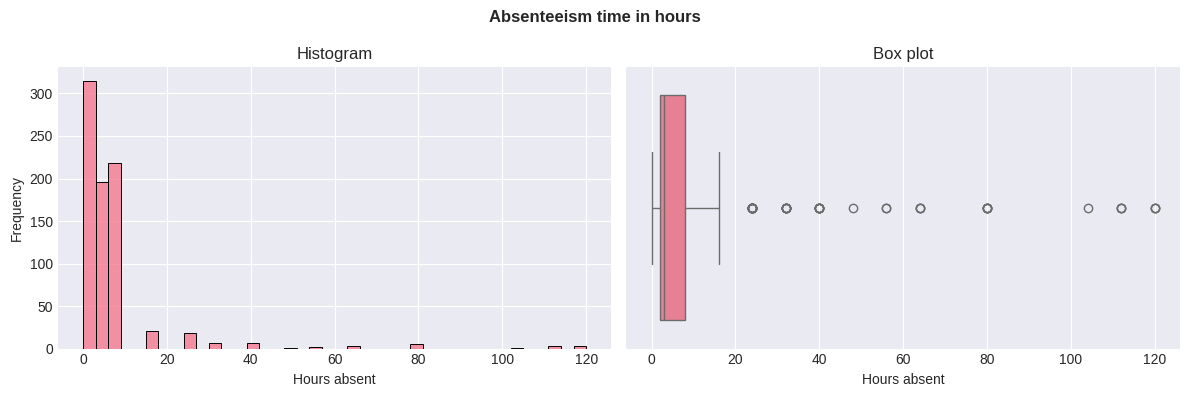

In [178]:
print("\n" + "-" * NUM_OF_DASHES)
print("Analyze Absenteeism Time in Hours")
print("-" * NUM_OF_DASHES)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.histplot(df["Absenteeism time in hours"], bins=40)
plt.xlabel("Hours absent")
plt.ylabel("Frequency")
plt.title("Histogram")

plt.subplot(1, 2, 2)
sns.boxplot(x=df["Absenteeism time in hours"])
plt.xlabel("Hours absent")
plt.title("Box plot")

plt.suptitle("Absenteeism time in hours", fontsize=12, fontweight="bold")
plt.tight_layout()
plt.show()



------------------------------------------------------------
Analyze Discrete Features
------------------------------------------------------------


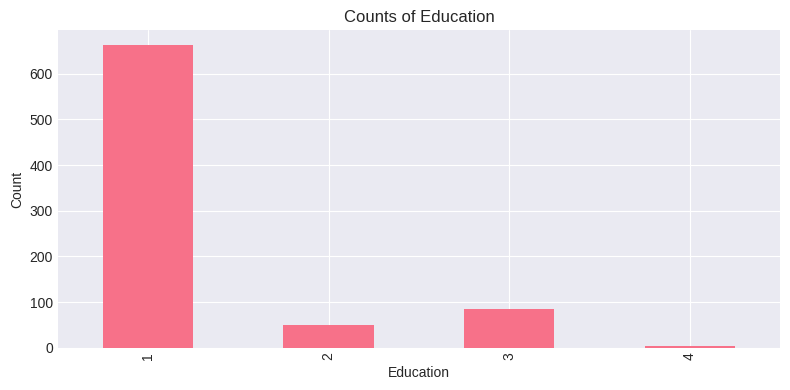

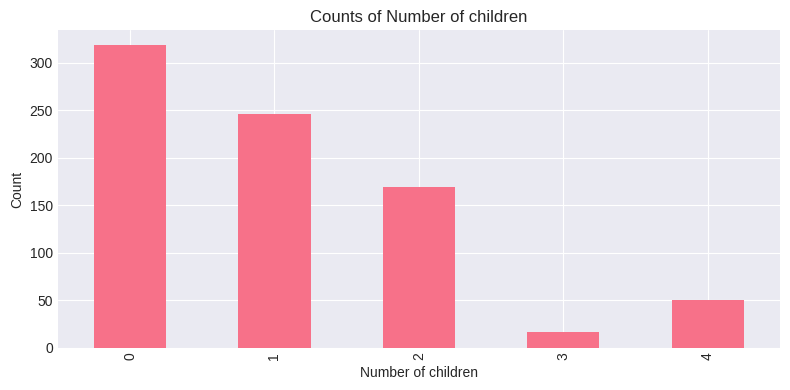

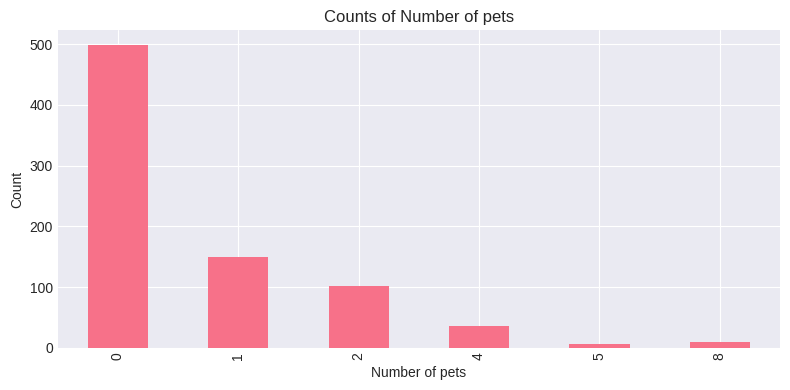

In [179]:
print("\n" + "-" * NUM_OF_DASHES)
print("Analyze Discrete Features")
print("-" * NUM_OF_DASHES)

discrete_features = ["Education", "Number of children", "Number of pets"]

for feature in discrete_features:
    plt.figure(figsize=(8, 4))
    df[feature].value_counts().sort_index().plot(kind="bar")
    plt.title(f"Counts of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


------------------------------------------------------------
Analyze Continuous Features
------------------------------------------------------------


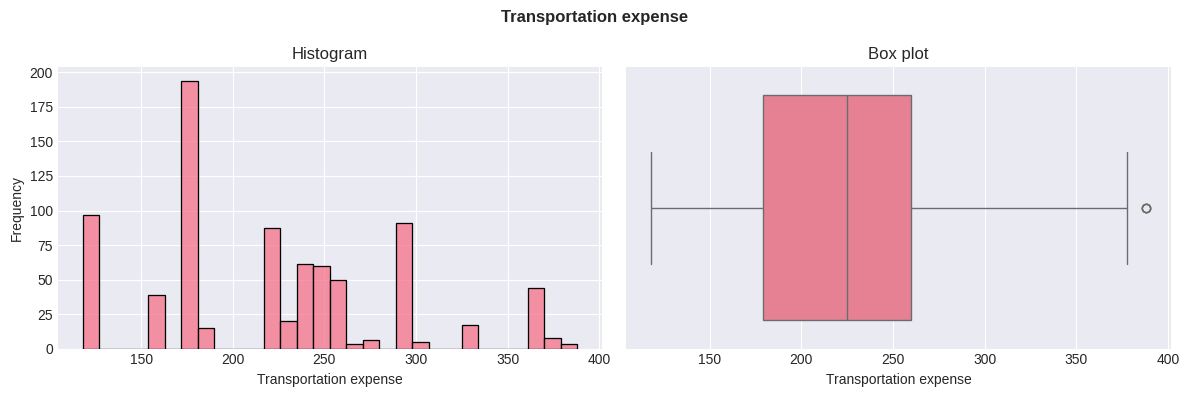

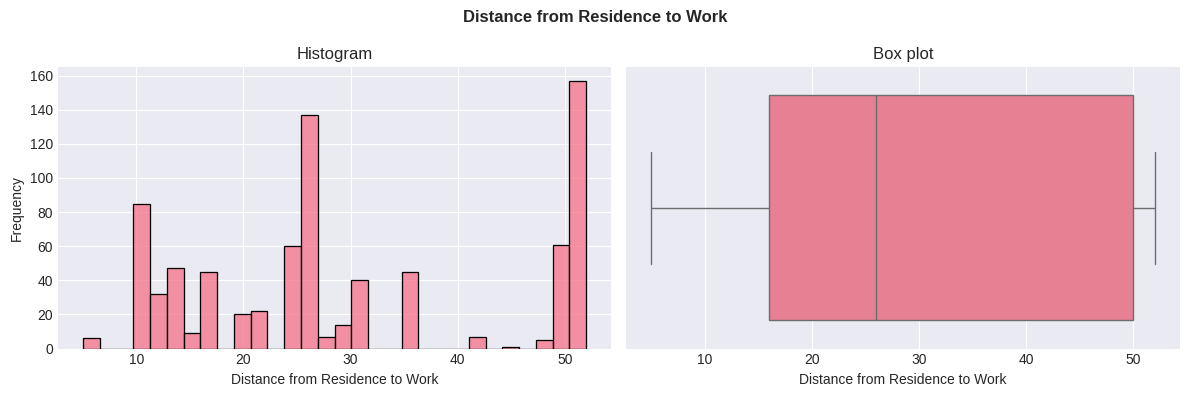

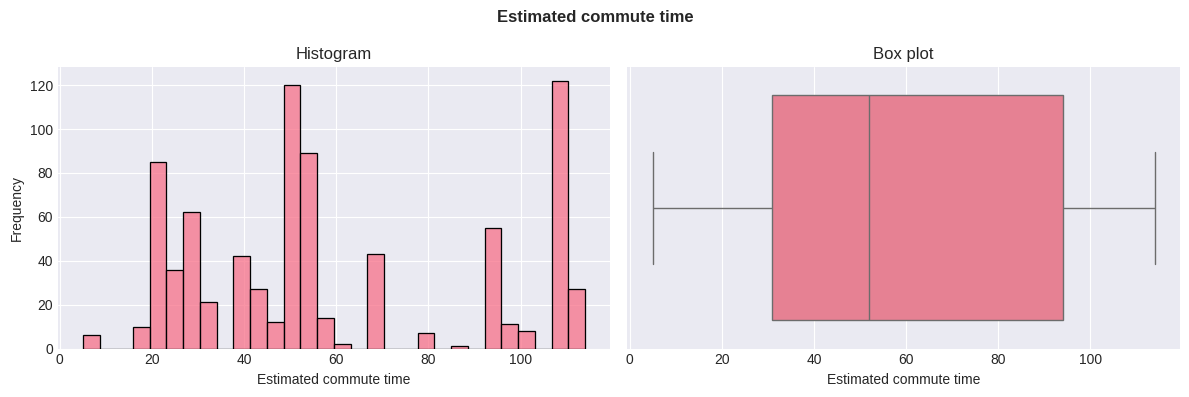

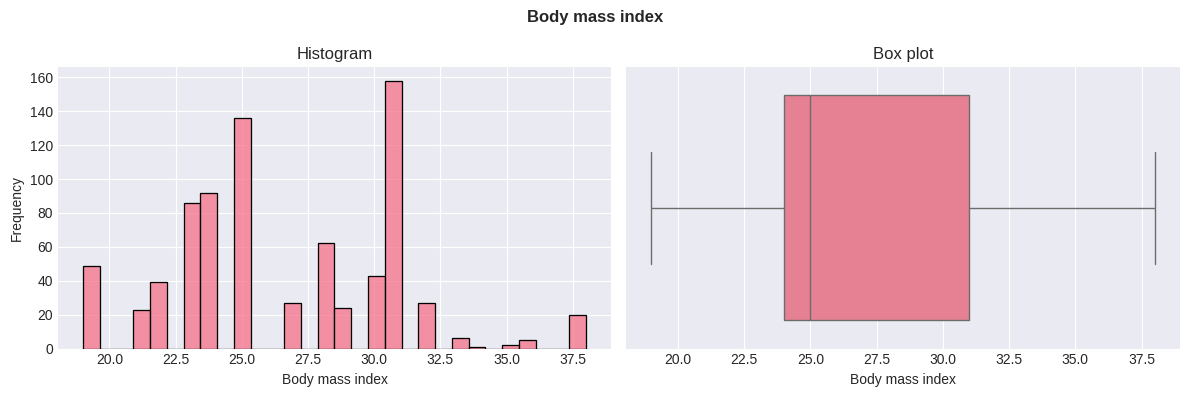

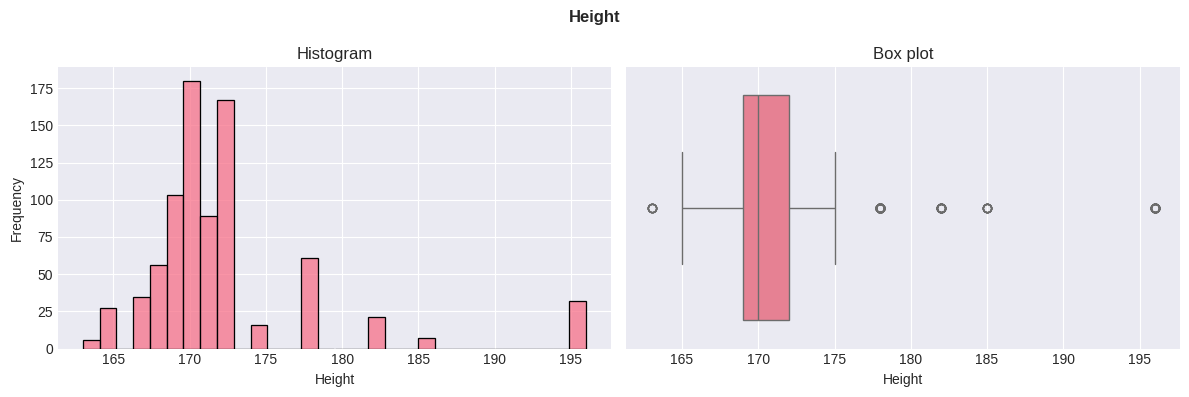

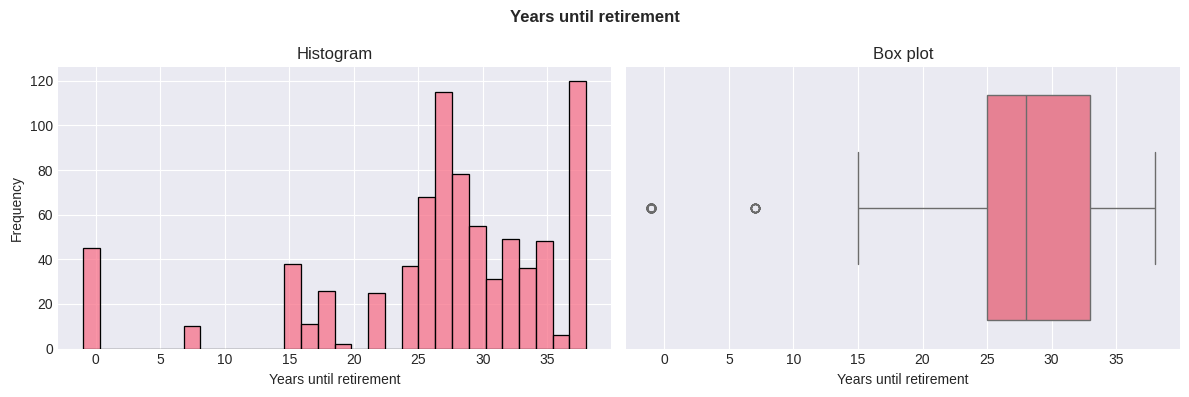

In [180]:
print("\n" + "-" * NUM_OF_DASHES)
print("Analyze Continuous Features")
print("-" * NUM_OF_DASHES)

continuous_features = [
    "Transportation expense",
    "Distance from Residence to Work",
    "Estimated commute time",
    "Body mass index",
    "Height",
    "Years until retirement",
]

for feature in continuous_features:
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    sns.histplot(df[feature], bins=30)
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.title("Histogram")

    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[feature])
    plt.xlabel(feature)
    plt.title("Box plot")

    plt.suptitle(f"{feature}", fontsize=12, fontweight="bold")
    plt.tight_layout()
    plt.show()



------------------------------------------------------------
Absenteeism vs Potential Drivers
------------------------------------------------------------


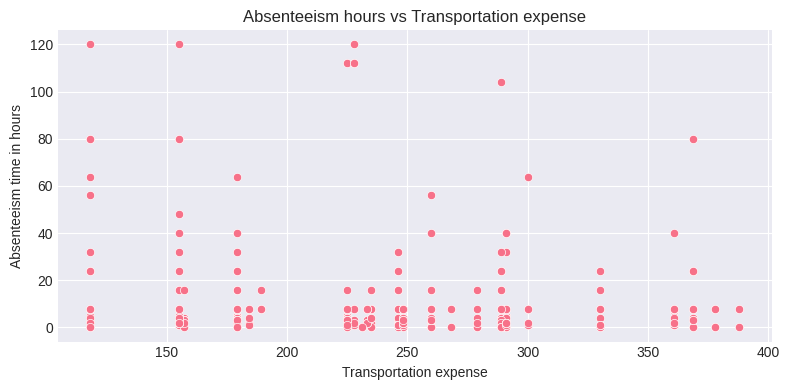

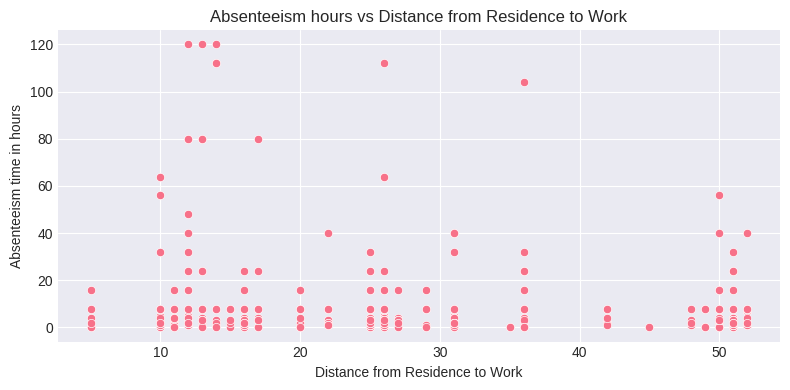

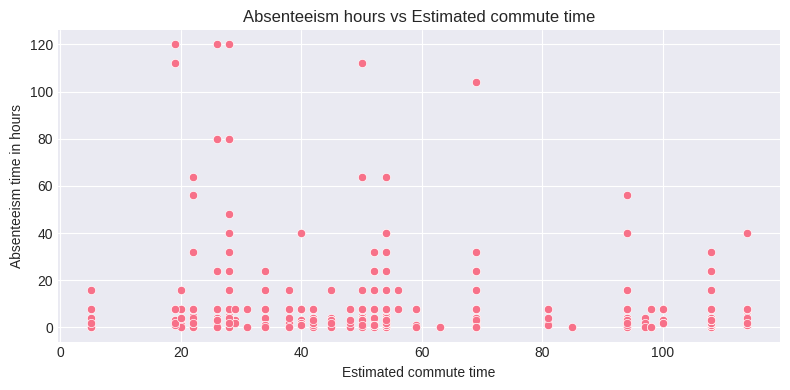

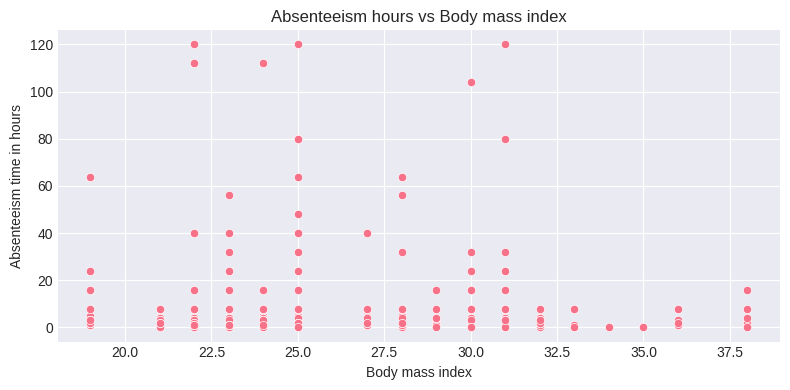

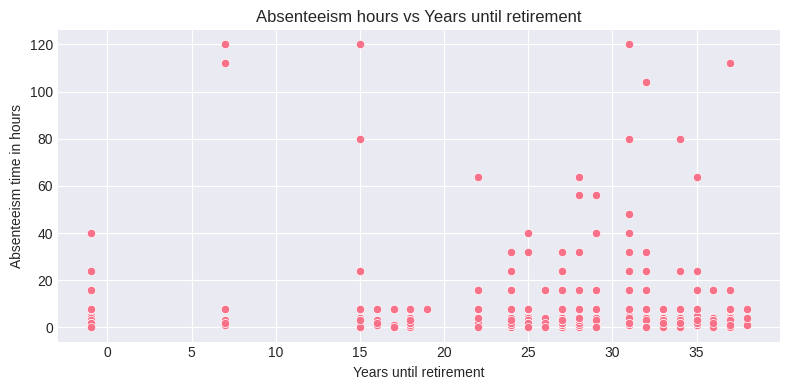

In [181]:
print("\n" + "-" * NUM_OF_DASHES)
print("Absenteeism vs Potential Drivers")
print("-" * NUM_OF_DASHES)

potential_drivers = [
    "Transportation expense",
    "Distance from Residence to Work",
    "Estimated commute time",
    "Body mass index",
    "Years until retirement",
]

for driver in potential_drivers:
    plt.figure(figsize=(8, 4))
    sns.scatterplot(x=df[driver], y=df["Absenteeism time in hours"])
    plt.title(f"Absenteeism hours vs {driver}")
    plt.xlabel(driver)
    plt.ylabel("Absenteeism time in hours")
    plt.tight_layout()
    plt.show()


------------------------------------------------------------
Correlation Matrix
------------------------------------------------------------


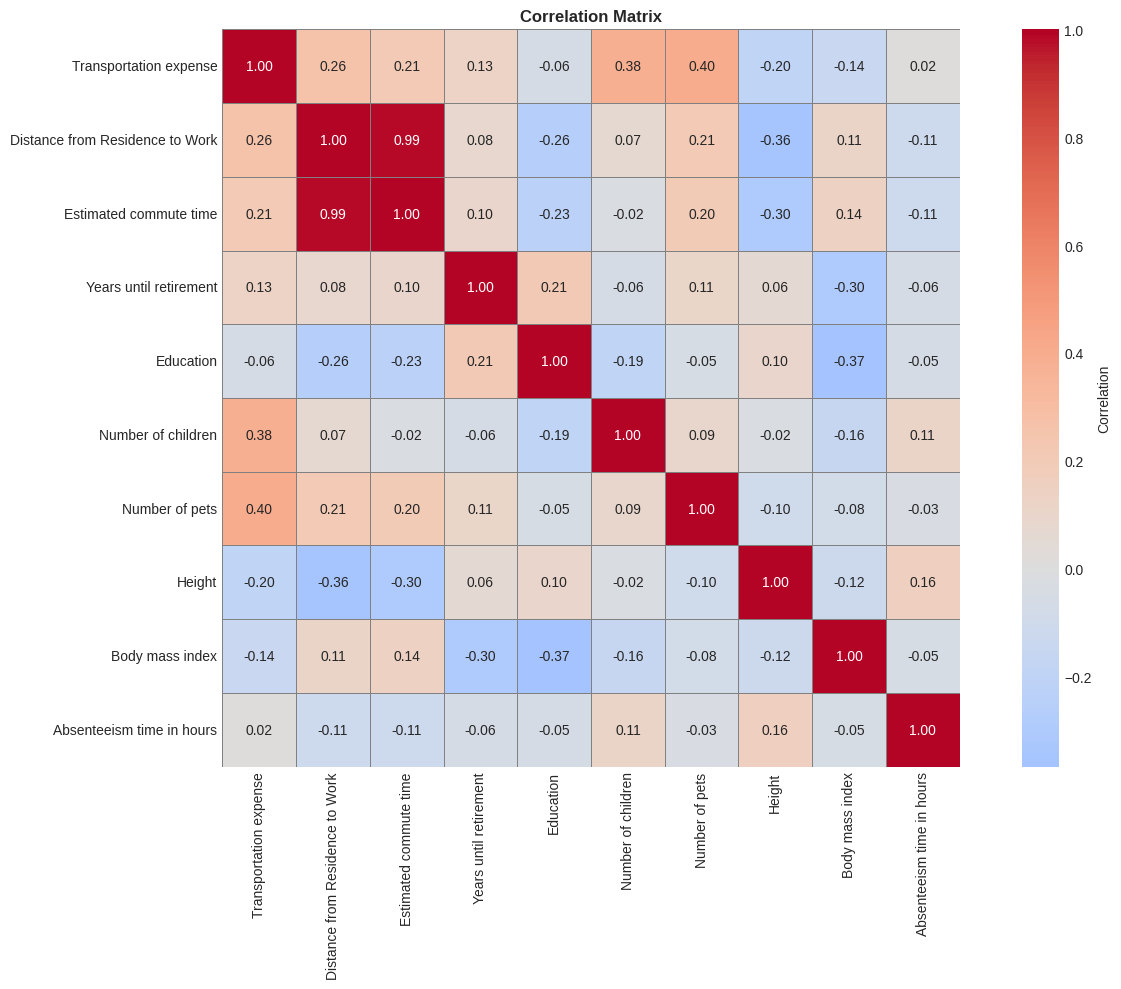

In [182]:
print("\n" + "-" * NUM_OF_DASHES)
print("Correlation Matrix")
print("-" * NUM_OF_DASHES)

# We need to remove the ID col in this analysis because it isn´t relevant
# Also, the "Days since previous absence" column only has zeroes, making it useless (so I also dropped this one)
numerical_df = df.select_dtypes(include="number").drop(columns=["ID", "Days since previous absence"])
corr_matrix = numerical_df.corr()

plt.figure(figsize=(14, 10))

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    center=0,
    square=True,
    cbar_kws={'label': 'Correlation'},
    linewidths=0.5,
    linecolor='gray'
)

plt.title('Correlation Matrix', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

### 2.3: Categorical Features Analysis


------------------------------------------------------------
Visual Analysis of Key Categorical Features
------------------------------------------------------------


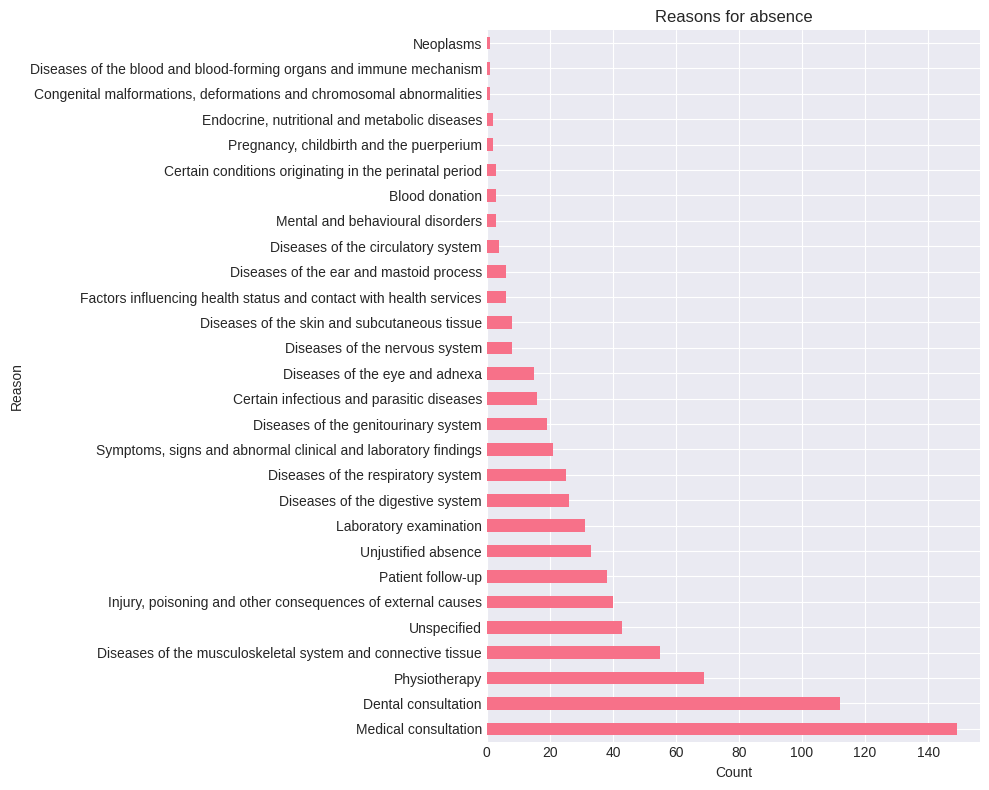

In [183]:
print("\n" + "-"*NUM_OF_DASHES)
print("Visual Analysis of Key Categorical Features")
print("-"*NUM_OF_DASHES)

plt.figure(figsize=(10, 8))
reason_counts = df["Reason for absence"].value_counts()
reason_counts.plot(kind="barh")
plt.title("Reasons for absence")
plt.xlabel("Count")
plt.ylabel("Reason")
plt.tight_layout()
plt.show()


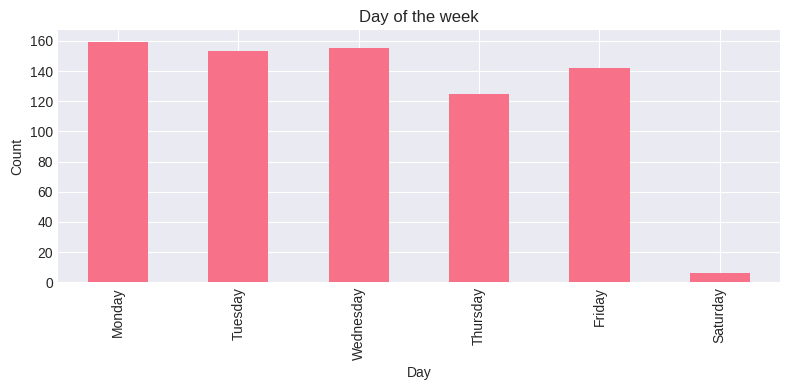

In [184]:
plt.figure(figsize=(8, 4))

day_order = ["Monday", "Tuesday", "Wednesday", "Thursday",
             "Friday", "Saturday", "Sunday"]

day_counts = df["Day of the week"].value_counts()
day_counts = day_counts.reindex([d for d in day_order if d in day_counts.index])

day_counts.plot(kind="bar")
plt.title("Day of the week")
plt.xlabel("Day")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

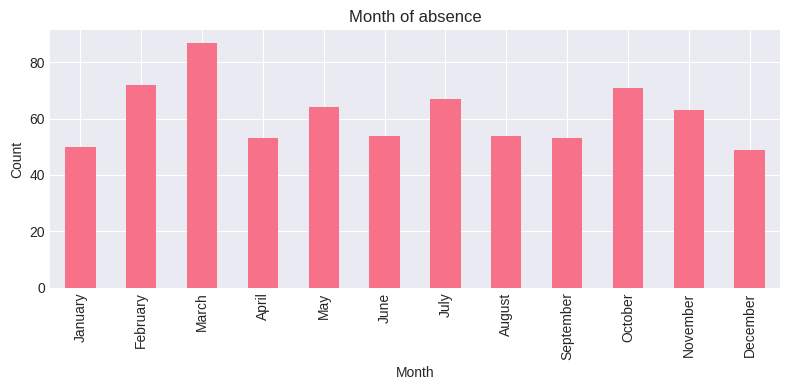

In [185]:
plt.figure(figsize=(8, 4))

month_order = ["January", "February", "March", "April", "May", "June",
               "July", "August", "September", "October", "November", "December"]

month_counts = df["Month of absence"].value_counts()
month_counts = month_counts.reindex([m for m in month_order if m in month_counts.index])

month_counts.plot(kind="bar")
plt.title("Month of absence")
plt.xlabel("Month")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

### 2.6: Age Analysis


------------------------------------------------------------
Age Analysis
------------------------------------------------------------


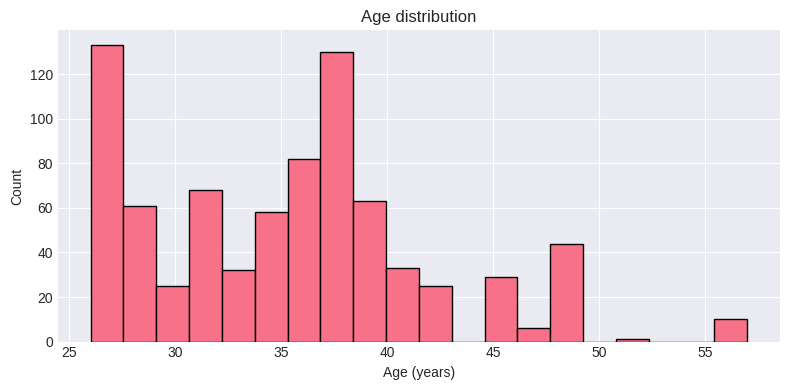

In [186]:
print("\n" + "-" * NUM_OF_DASHES)
print("Age Analysis")
print("-" * NUM_OF_DASHES)

df["Age"] = (REFERENCE_DATE - pd.to_datetime(df["Date of Birth"])).dt.days // 365

plt.figure(figsize=(8, 4))
df["Age"].hist(bins=20, edgecolor="black")
plt.title("Age distribution")
plt.xlabel("Age (years)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

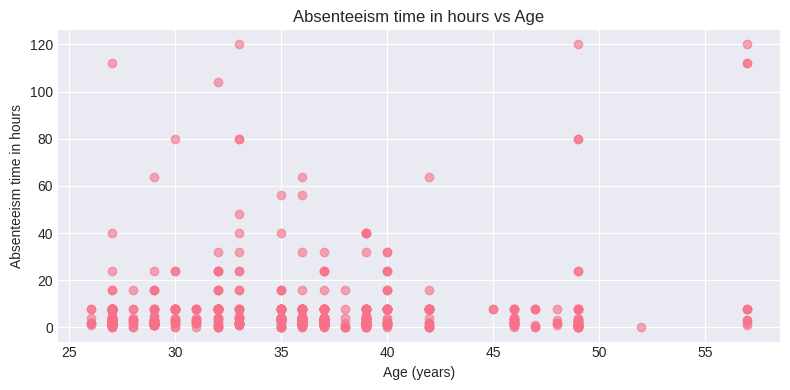

In [187]:
plt.figure(figsize=(8, 4))
plt.scatter(df["Age"], df["Absenteeism time in hours"], alpha=0.6)
plt.title("Absenteeism time in hours vs Age")
plt.xlabel("Age (years)")
plt.ylabel("Absenteeism time in hours")
plt.tight_layout()
plt.show()

### 2.7: Key Insights From The Data







- **Highly skewed absenteeism:** Most employees have no or few hours absent. However, there are some employees that have very long absences (for example, up to 120 hours).

- **Commute as a weak direct driver:** Transportation expense, distance, and estimated commute time are highly correlated with each other. However, these features seem to not be highly related to absenteeism. This could show that a commute burden index may differentiate employee profiles without being the main absenteeism driver.

- **Reasons are usually valid:** The majority of absences here are due to medical (or other) justified reasons. However, there is a small number linked to unspecified or disciplinary causes. These could flag higher‑risk groups in later clustering.

- **Calendar patterns:** Absences appear to be relatively balanced across months and seasons.

- **Employee profile:** Employees at this company are usually young to middle aged. Also, age only shows only a weak relationship with absenteeism. Because of this, age may be useful for describing clusters but may not be a dominant absenteeism driver.

- **Data quality issues:** Near‑constant variables, inconsistent categorical labels, and irregular entries in "Weight" demonstrate the need for careful cleaning and feature selection before clustering.

## 3.0: Data Pre-Processing

Now that we've explored the data, we need to clean it up before clustering. 
This section covers:

1. **Missing Value Handling**: Fixing gaps in the data

2. **Outlier Handling**:  Dealing with extreme values

3. **Fixing Inconsistent Data**: Standardizing categories

4. **Feature Engineering**: Creating new useful features

5. **Data Transformation**: Scaling and encoding for the model

### 3.1: Missing Value Handling

In [188]:
print("-" * NUM_OF_DASHES)
print("Missing Value Handling")
print("-" * NUM_OF_DASHES)

# 1. Seasons: Forward Fill
# Deleting records with 28% missingness would create a biased subset
# Since absence data is temporal, Forward Fill is appropriate to estimate the missing value based on the previous valid observation
df['Seasons'] = df['Seasons'].ffill()

# 2. Month and Day: Drop Rows
# Missingness is low (~7%). Imputing these temporal features could introduce noise or incoherencies
# The minor data loss is acceptable to maintain overall data quality
df.dropna(subset=['Month of absence', 'Day of the week'], inplace=True)

# 3. Reason for Absense: Create "Unknown" Category
# Instead of imputing with the mode (which may be inaccurate), we treat missingness as a valid, informative category
# This approach is equivalent to filling categorical values with a constant placeholder
df['Reason for absence'] = df['Reason for absence'].fillna('Unknown')

# 4. Days since previous absence: Fill with Constant (0)
# A missing value likely indicates no prior recorded absence
df['Days since previous absence'] = df['Days since previous absence'].fillna(0)

remaining_missing = df.isnull().sum().sum()
print("\nVerification:")
if remaining_missing == 0:
    print("SUCCESS: All missing values handled. (Total missing: 0)")
else:
    print(f"WARNING: {remaining_missing} missing values remain.")



------------------------------------------------------------
Missing Value Handling
------------------------------------------------------------

Verification:
SUCCESS: All missing values handled. (Total missing: 0)


### 3.3: Outlier Detection

In [189]:
print("-" * NUM_OF_DASHES)
print("Outlier Handling")
print("-" * NUM_OF_DASHES)
print("")

# IQR = Q3 - Q1. Upper Bound = Q3 + 1.5 * IQR

# Features selected for clipping:
# - Height: Extreme values likely due to data entry errors
# - Transportation expense: Extreme costs may reflect errors or exceptional cases that would skew distance-based clustering

# Features NOT clipped:
# - Absenteeism time in hours: Extreme values represent high-risk employees, which are critical to our analysis
# - Number of pets / Education: Outliers fall within valid, realistic ranges and provide informative variation

outlier_features = ['Height', 'Transportation expense']

for feature in outlier_features:
    # calculate IQR bounds
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    upper_limit = Q3 + 1.5 * IQR
    
    # store old max for comparison
    old_max = df[feature].max()
    
    # apply clipping
    df[feature] = df[feature].clip(upper=upper_limit)
    
    # report result
    new_max = df[feature].max()
    if old_max > new_max:
        print(f"{feature:<30} Capped at {upper_limit:.2f} (Was {old_max:.2f})")
    else:
        print(f"{feature:<30} No outliers above {upper_limit:.2f} (Max: {old_max:.2f})")

print("\nVerification:")
print("Outlier treatment complete. Extreme values clipped to preserve data integrity.")


------------------------------------------------------------
Outlier Handling
------------------------------------------------------------

Height                         Capped at 176.50 (Was 196.00)
Transportation expense         Capped at 381.50 (Was 388.00)

Verification:
Outlier treatment complete. Extreme values clipped to preserve data integrity.


### 3.3 Fixing Inconsistent Data

In [190]:
print("-" * NUM_OF_DASHES)
print("Fixing Inconsistent Data")
print("-" * NUM_OF_DASHES)

# 1. Social drinker: Map 'Y', 'Yes' -> 1, 'N', 'No' -> 0
df['Social drinker'] = df['Social drinker'].map({
    'Y': 1, 'Yes': 1, 
    'N': 0, 'No': 0
}).fillna(0)

# 2. Social smoker: Map 'Yes' -> 1, 'No' -> 0
df['Social smoker'] = df['Social smoker'].map({
    'Yes': 1, 'No': 0
}).fillna(0).astype(int)

# 3. Disciplinary failure: Map 'Yes' -> 1, 'No' -> 0
df['Disciplinary failure'] = df['Disciplinary failure'].map({
    'Yes': 1, 'No': 0
}).fillna(0)

# 4. Service time: Convert to numeric to handle potential non-numeric entries
df['Service time'] = pd.to_numeric(df['Service time'], errors='coerce')
# Replace any created NaNs with median
df['Service time'] = df['Service time'].fillna(df['Service time'].median())

# 5. Weight: Convert to numeric (some items in weight weren't a number)
df['Weight'] = pd.to_numeric(df['Weight'], errors='coerce')
df['Weight'] = df['Weight'].fillna(df['Weight'].median())

# 6. Remove "Saturday" from Day of the week
# A standard work week is Mon-Fri. Saturday entries (n=6) are likely data errors OR are simply outliers we don't really want to consider.
initial_rows = len(df)
df = df[df['Day of the week'] != 'Saturday']
rows_dropped = initial_rows - len(df)
print(f"\nDropped {rows_dropped} rows with 'Day of the week' = 'Saturday'")

print("\nVerification:")
cols_to_check = ['Social drinker', 'Social smoker', 'Disciplinary failure']
for col in cols_to_check:
    print(f"{col:<25} Unique Values: {df[col].unique()}")

print(f"{'Service time':<25} Dtype: {df['Service time'].dtype}")
print(f"{'Weight':<25} Dtype: {df['Weight'].dtype}")

------------------------------------------------------------
Fixing Inconsistent Data
------------------------------------------------------------

Dropped 6 rows with 'Day of the week' = 'Saturday'

Verification:
Social drinker            Unique Values: [1 0]
Social smoker             Unique Values: [0 1]
Disciplinary failure      Unique Values: [0 1]
Service time              Dtype: float64
Weight                    Dtype: float64


### 3.4: Feature Engineering

In [191]:
print("-" * NUM_OF_DASHES)
print("Feature Engineering")
print("-" * NUM_OF_DASHES)

# 1. Create 'Age' from 'Date of Birth'
# Date-type fields may become obsolete... use date of birth, then derive Age"
df['Date of Birth'] = pd.to_datetime(df['Date of Birth'])
df['Age'] = ((REFERENCE_DATE - df['Date of Birth']).dt.days // 365)

# 2. Create 'Commute_Burden_Index'
# Combines Distance, Time, and Expense into a single "burden" score.
# This helps identify employees with difficult commutes more effectively than looking at variables individually.
# Formula: Weighted average of normalized commute variables (weights sum to 1.0)
df['Commute_Burden_Index'] = (
    (df['Transportation expense'] / df['Transportation expense'].max()) * 0.3 +
    (df['Distance from Residence to Work'] / df['Distance from Residence to Work'].max()) * 0.35 +
    (df['Estimated commute time'] / df['Estimated commute time'].max()) * 0.35
)

# 3. Create 'Home_Responsibility_Index'
# Employees with more children and pets likely face higher non-work demands.
# Simple additive index to capture "home responsibility."
df['Home_Responsibility_Index'] = df['Number of children'] + df['Number of pets']

# Verification
print("\nNew Features Created:")
print(f"{'Age':<25} Range: {df['Age'].min()} - {df['Age'].max()} years")
print(f"{'Commute_Burden_Index':<25} Range: {df['Commute_Burden_Index'].min():.3f} - {df['Commute_Burden_Index'].max():.3f}")
print(f"{'Home_Responsibility_Index':<25} Range: {df['Home_Responsibility_Index'].min()} - {df['Home_Responsibility_Index'].max()}")

# Drop original 'Date of Birth' because it is no longer needed
df.drop(columns=['Date of Birth'], inplace=True)
print("\nDropped redundant feature: 'Date of Birth'")


------------------------------------------------------------
Feature Engineering
------------------------------------------------------------

New Features Created:
Age                       Range: 26 - 57 years
Commute_Burden_Index      Range: 0.228 - 0.984
Home_Responsibility_Index Range: 0 - 9

Dropped redundant feature: 'Date of Birth'


### 3.5 Data Transformation

In [192]:
print("-" * NUM_OF_DASHES)
print("Data Transformation (Scaling & Encoding)")
print("-" * NUM_OF_DASHES)
print("")

# 1. define feature sets
# exclude 'ID' (irrelevant) and 'Absenteeism time in hours' (target)
features_to_exclude = ['ID', 'Absenteeism time in hours']

# features to scale
features_to_scale = ['Transportation expense', 'Distance from Residence to Work', 
                     'Service time', 'Age', 'Home_Responsibility_Index', 
                     'Commute_Burden_Index', 'Body mass index', 'Height', 'Weight']

# 2. one-hot encoding for categorical variables
categorical_cols = ['Reason for absence', 'Month of absence', 'Day of the week', 'Seasons']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# 3. scaling (continuous) numerical features
scaler = StandardScaler()
df_encoded[features_to_scale] = scaler.fit_transform(df_encoded[features_to_scale])

# 4. final clustering dataset
X = df_encoded.drop(columns=features_to_exclude, errors='ignore')

print("Transformation Complete.")
print(f"Original Feature Count: {df.shape[1]}")
print(f"New Feature Count (after encoding): {X.shape[1]}")
print("\nFirst 5 rows of scaled data (subset):")
X[features_to_scale].head()

------------------------------------------------------------
Data Transformation (Scaling & Encoding)
------------------------------------------------------------

Transformation Complete.
Original Feature Count: 24
New Feature Count (after encoding): 63

First 5 rows of scaled data (subset):


,Transportation expense,Distance from Residence to Work,Service time,Age,Home_Responsibility_Index,Commute_Burden_Index,Body mass index,Height,Weight
0,1.01,0.43,0.10,-0.53,0.70,0.59,0.78,0.33,0.85
1,-1.54,-1.12,1.26,2.10,-0.42,-1.37,1.01,1.85,1.50
2,-0.63,1.44,1.26,0.25,-0.98,1.22,1.01,-0.34,0.77
3,0.86,-1.66,0.34,0.40,0.14,-1.34,-0.63,-1.01,-0.93
4,1.01,0.43,0.10,-0.53,0.70,0.59,0.78,0.33,0.85


### 3.6: Justification of Steps Taken



## **4.0: Clustering**

### 4.1: Feature Selection

In [193]:
print("-" * NUM_OF_DASHES)
print("Feature Selection for Clustering")
print("-" * NUM_OF_DASHES)

all_columns = X.columns.tolist()
print(f"\nTotal features after pre-processing: {len(all_columns)}")

# we want to build a list of columns to keep for clustering
clustering_columns = []
for column in all_columns:
    # skip columns that don't tell you anything about the characteristics of the employee
    if column.startswith("Reason"):
        continue
    if column.startswith("Day"):
        continue
    if column.startswith("Month"):
        continue
    if column.startswith("Seasons"):
        continue
    
    clustering_columns.append(column)

# create final clustering dataset
X_cluster = X[clustering_columns].copy()

print(f"\nSelected {len(clustering_columns)} features:")
features_df = pd.DataFrame({
    'Feature Name': clustering_columns
})
features_df


------------------------------------------------------------
Feature Selection for Clustering
------------------------------------------------------------

Total features after pre-processing: 63

Selected 17 features:


,Feature Name
0,Transportation expense
1,Distance from Residence to Work
2,Estimated commute time
3,Service time
4,Years until retirement
5,Disciplinary failure
6,Education
7,Number of children
8,Social drinker
9,Social smoker


### 4.2: Determining Number of Clusters

In [194]:
print("\n" + "-" * NUM_OF_DASHES)
print("Determining Optimal K")
print("-" * NUM_OF_DASHES)

metrics = {
    'k': [],
    'inertia': [],
    'silhouette': []
}

print("\nTesting K-Means.")
print(f"\n{'K':<5} {'Inertia (SSE)':<15} {'Silhouette':<12}")
print("-" * 35)

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10, max_iter=300)
    labels = kmeans.fit_predict(X_cluster)
    
    # get the validation metrics
    sil = silhouette_score(X_cluster, labels)
    
    metrics['k'].append(k)
    metrics['inertia'].append(kmeans.inertia_)
    metrics['silhouette'].append(sil)
    
    print(f"{k:<5} {kmeans.inertia_:<15.2f} {sil:<12.3f}")

# save results
metrics_df = pd.DataFrame(metrics)

# figure out which k is best for silhouette
best_silhouette_k = metrics_df.loc[metrics_df['silhouette'].idxmax(), 'k']

print("\nBest K by Silhouette Score:")
print(f"  k = {int(best_silhouette_k)} (score: {metrics_df['silhouette'].max():.3f})")
print("\nFor Inertia (SSE), look for the 'elbow' in the plot (next section)")


------------------------------------------------------------
Determining Optimal K
------------------------------------------------------------

Testing K-Means.

K     Inertia (SSE)   Silhouette  
-----------------------------------
2     205380.75       0.671       
3     110109.48       0.565       
4     86430.46        0.570       
5     73063.26        0.590       
6     60727.28        0.569       
7     50515.59        0.545       
8     40130.68        0.574       
9     30236.45        0.624       
10    23962.90        0.661       

Best K by Silhouette Score:
  k = 2 (score: 0.671)

For Inertia (SSE), look for the 'elbow' in the plot (next section)



------------------------------------------------------------
Visualizing Optimal K
------------------------------------------------------------


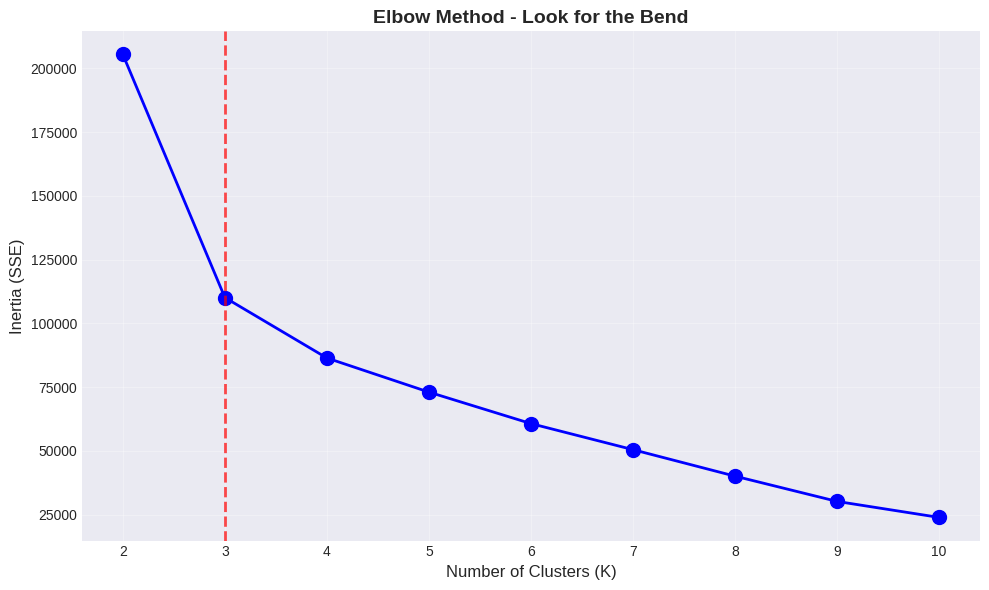

In [195]:
print("\n" + "-" * NUM_OF_DASHES)
print("Visualizing Optimal K")
print("-" * NUM_OF_DASHES)

plt.figure(figsize=(10, 6))
plt.plot(metrics_df['k'], metrics_df['inertia'], 'bo-', linewidth=2, markersize=10)
plt.axvline(x=3, color='red', linestyle='--', linewidth=2, alpha=0.7)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Inertia (SSE)', fontsize=12)
plt.title('Elbow Method - Look for the Bend', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(range(2, 11))
plt.tight_layout()
plt.show()

# k = 3 being the optimal value makes the most sense
# this way, we may also be abale to identify "low-risk", "medium-risk", and "high-risk" individuals (three clusters)
optimal_k = 3

### 4.3: Comparing Clustering Algorithms

In [196]:
print("\n" + "-" * NUM_OF_DASHES)
print(f"Comparing Clustering Algorithms (K={optimal_k})")
print("-" * NUM_OF_DASHES)
print("")

# store all the clustering results
algorithms = {}

# 1. K-Means
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init=10)
algorithms['K-Means'] = kmeans.fit_predict(X_cluster)

# 2. hierarchical clustering (ward linkage)
hierarchical = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
algorithms['Hierarchical (Ward)'] = hierarchical.fit_predict(X_cluster)

# 3. hierarchical clustering (avg linkage)
hierarchical_avg = AgglomerativeClustering(n_clusters=optimal_k, linkage='average')
algorithms['Hierarchical (Average)'] = hierarchical_avg.fit_predict(X_cluster)

# 4. Gaussian Mixture Model
gmm = GaussianMixture(n_components=optimal_k, random_state=42)
algorithms['Gaussian Mixture'] = gmm.fit_predict(X_cluster)

best_score = -1
best_algo = ""

for name, labels in algorithms.items():
    sil = silhouette_score(X_cluster, labels)
    print(f"{name:<25} {sil:<20.3f}")
    
    if sil > best_score:
        best_score = sil
        best_algo = name

print(f"\nBest algorithm: {best_algo} (Silhouette: {best_score:.3f})\n")

# use the best algorithm's labels
final_labels = algorithms[best_algo]

# add cluster labels to the original dataframe
df['Cluster'] = final_labels

# show cluster distribution
cluster_counts = df['Cluster'].value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    pct = count / len(df) * 100
    print(f"Cluster {cluster_id}: {count:3d} employees: {pct:5.1f}%")



------------------------------------------------------------
Comparing Clustering Algorithms (K=3)
------------------------------------------------------------

K-Means                   0.565               
Hierarchical (Ward)       0.561               
Hierarchical (Average)    0.523               
Gaussian Mixture          0.564               

Best algorithm: K-Means (Silhouette: 0.565)

Cluster 0: 207 employees:  28.3%
Cluster 1: 267 employees:  36.5%
Cluster 2: 257 employees:  35.2%


In [197]:
print("\n" + "-" * NUM_OF_DASHES)
print("Cluster Profiling")
print("-" * NUM_OF_DASHES)

comparison_data = {'Feature': clustering_columns}
for cluster_id in sorted(df['Cluster'].unique()):
    cluster_means = df[df['Cluster'] == cluster_id][clustering_columns].mean()
    comparison_data[f'Cluster {cluster_id}'] = cluster_means.values

comparison_data['Overall'] = df[clustering_columns].mean().values
comparison_df = pd.DataFrame(comparison_data)

comparison_df


------------------------------------------------------------
Cluster Profiling
------------------------------------------------------------


,Feature,Cluster 0,Cluster 1,Cluster 2,Overall
0,Transportation expense,230.11,198.78,237.87,221.39
1,Distance from Residence to Work,50.45,14.78,28.21,29.60
2,Estimated commute time,103.86,28.31,54.76,59.00
3,Service time,13.70,12.90,11.25,12.55
4,Years until retirement,27.14,24.14,28.83,26.64
5,Disciplinary failure,0.04,0.08,0.04,0.05
6,Education,1.03,1.39,1.40,1.29
7,Number of children,1.02,1.12,0.91,1.02
8,Social drinker,0.90,0.40,0.48,0.57
9,Social smoker,0.04,0.10,0.06,0.07


In [198]:
# absenteeism stats
print("\n" + "-" * NUM_OF_DASHES)
print("Absenteeism Statistics")
print("-" * NUM_OF_DASHES)

absence_stats = df.groupby('Cluster')['Absenteeism time in hours'].agg([
    ('Count', 'count'),
    ('Mean', 'mean'),
    ('Median', 'median'),
    ('Std', 'std'),
    ('Min', 'min'),
    ('Max', 'max')
]).round(2)

absence_stats


------------------------------------------------------------
Absenteeism Statistics
------------------------------------------------------------


,Count,Mean,Median,Std,Min,Max
Cluster,,,,,,
0,207,5.25,3.00,6.55,0,56
1,267,8.36,3.00,17.57,0,120
2,257,6.88,3.00,12.35,0,112
